# Cut-it

David Alsina, Isabela Cáceres, y Camilo Martinez

En este proyecto la idea es desarrollar un algorithmo de segmentación de imagenes a color, utilizando el Mean  Sift y partición de grafos. Ustedes deben realizar la implementación tanto del algoritmo de mean-shift como el de grafos. Para esto pueden seguir las indicaciones explicadas a continuación.

## Algoritmo de mean-shift

Este algoritmo tiene como datos de entrada el tamaño de la region de busqueda (radio de busqueda). El algoritmo toma cada pixel de la imagen, expresado en un espacio de color LUV, RGB o HSI, deberian hacerlo generico para que el algoritmo realice la segmentación, independientemente del tipo de formato de color utilizado.

El algoritmo consiste en los siguientes pasos:
1. para cada pixel, determinar un entorno de radio r, radio de búsqueda.
2. Calcular el centro de masa de los puntos dentro del radio. 
3. Encontrar los elementos en un radio r alrededor del centro de masa calculado en el paso anterior.
4. Repetir el paso 3 hasta convergencia.
5. repetir desde el paso 2 para cada uno de los puntos que representa la imagen.
6. Identificar cuantos modos hay en la imagen. Los modos son los puntos a los que convergen los pixeles de la imagen.
7. Todos los pixeles que convergen a un modo se agrupan en un mismo conjunto. Cada uno de estos segnmentos es una region conexa de pixeles en la imagen.

## Algoritmo basado en grafos.

Este algoritmo se basa en el clustering espectral. Junto a este proyecto pueden encontrar un paper qu eexplica en que consiste este método. En si el proceso a realizar es el siguiente:

1. Construir el grafo de la imagen.
2. Encontrar el La matrix Laplaciana del grafo.
3. Realizar una descomposicion en valores singulares de la imagen, buscando el eigenvector asociado al segundo eigenvalor más pequeño de la imagen.
4. Graficar este eigenvector organizando los valores de menor a mayor (deben hacer tracking de los indices al organizar este vector)
5. Los elementos (posiciones del eigenvector) que tienen un valor similar, corresponden a elementos conexos en la imagen.
6. Determine umbrales para segmentar la imagen en regiones conexas.


Para la entrega del proyecto deben proporcionar lo siguiente:

1. Implementación de los algoritmos.
2. Prueba de los algoritmos utilizando diferentes imagenes y representaciones en espacio de color.
3. Gráficas de los clusters encontrados (modos y sus regiones), asi como de los eigenvectores.
4. Discusion de la implementación.
5. Discusion de los resultados obtenidos, ventajas y desventajas de cada método.
6. Posibles mejoras.

Para la implementación con grafos tengan en cuenta que se debe realizar la descomposicion en valores singulares de una matrix tamaño $N\times N$, donde $N$ res el número de pixeles en la imagen. Como esto es computacionalmente muy costoso, hay dos opciones. La primera es usar imagenes pequeñas, pero estas imagenes serían tal vez demasiado pequeñas (tamaños inferiores a $100\times 100$). Otra opción es hacer que cada nodo no sea un pixel, sino un superpixel, de esta forma se puede reducir bastante la complejidad del algoritmo.

El proyecto lo deben entregar el **Lunes 9 de Mayo a las 11:59 p.m**. Se pueden hacer en grupos de dos personas y admito un grupo de tres personas. Mucha suerte!!

In [1]:
!pip install opencv-python
# apt-get update && apt-get install -y python3-opencv

In [9]:
#para trabajar la imagen :D
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from scipy import ndimage

https://www.geeksforgeeks.org/image-segmentation-using-k-means-clustering/ 


(231840, 3)
(420, 552, 3)


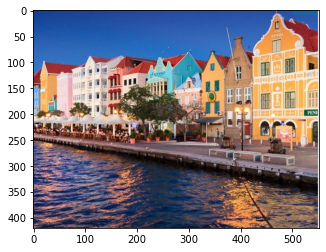

In [3]:
img = cv2.imread('casitas.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_flat = img.reshape((-1, 3))

print(img_flat.shape)
print(img.shape)
plt.imshow(img);

52924710.38139874 [[34]
 [34]
 [34]
 ...
 [20]
 [13]
 [43]] [[161.48795  135.38506  131.10437 ]
 [ 56.552536  45.007618  35.217777]
 [ 38.035545  85.18107  167.86464 ]
 [234.8438   186.6475   165.55923 ]
 [129.89993   44.00031   39.655064]
 [ 98.681366  81.96404   92.66578 ]
 [245.24843  166.6404    79.32926 ]
 [195.94345  175.84276  170.03052 ]
 [ 33.474915  41.69625   62.961784]
 [211.23163  197.0923   193.08752 ]
 [165.72186   50.03849   48.52687 ]
 [ 16.443869   9.41408    8.009563]
 [138.33665   84.98525   62.282467]
 [247.27235  234.24461  226.04366 ]
 [ 48.770462 110.9484   191.6502  ]
 [169.60693  194.58775  214.28613 ]
 [182.55074  104.90505   66.89755 ]
 [ 51.125473  52.894672  77.02035 ]
 [ 81.540535  85.97071  120.216866]
 [217.86414  150.9106   109.60964 ]
 [118.701355 100.86713  114.324104]
 [250.48589  227.99487  201.50984 ]
 [108.46698  164.29364  190.4033  ]
 [243.30957  179.45656  106.14934 ]
 [221.32745  170.24918  138.8881  ]
 [ 81.38311   36.032448  21.10555 ]
 [10

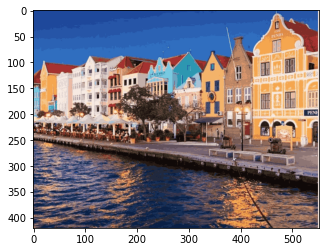

In [4]:
#the below line of code defines the criteria for the algorithm to stop running,
#which will happen is 100 iterations are run or the epsilon (which is the required accuracy)
#becomes 85%
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
 

k = 50
retval, labels, centers = cv2.kmeans(img_flat.astype('float32'), k,
                                     None, criteria,
                                     10, cv2.KMEANS_PP_CENTERS)

print(retval, labels, centers)

# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((img.shape))
 
plt.imshow(segmented_image)                                     

In [5]:
def gen_window_indx(img: np.ndarray, center: tuple, radius: int) -> tuple:
    """genera lista de indices de filas y de columnas que corresponden a la ventana (circulo)"""
    rows=[]
    cols= []
    r = radius
    h, k = center
    x0, y0 = h - r, k - r
    for i in range(2*r+1):
        x= x0+i
        if (x < 0) or (x > img.shape[0]-1): continue
        for j in range(2*r+1):
            y = y0+j
            if y < 0 or (y > img.shape[1]-1): continue
            if ((x-h)**2 + (y-k)**2 <= r**2):
                #img[x,y]=0
                rows.append(x)
                cols.append(y)
    return rows, cols

In [6]:
def isolate_window(img: np.ndarray, center: tuple, radius: int) -> np.ndarray:
    """Aisla la ventana en la imagen. Es decir, hace todo cero menos los
    valores que estan dentro de la ventana (dentro del circulo)"""
    img_copy = copy.deepcopy(img)
    rows, cols = gen_window_indx(img_copy, center, radius)
    img_copy[rows,cols] = 0
    img_copy = img - img_copy

    return img_copy

In [7]:
ones = np.ones((11,11))
isolate_window(ones,(4,4),4)

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(205, 299)


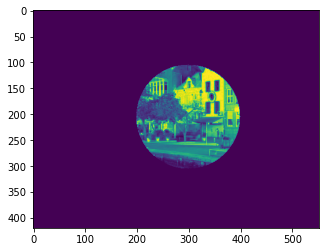

In [18]:
img_ch = img[:,:,0]
r = 100

window_center = ndimage.center_of_mass(img_ch)
window_center = tuple(np.floor(window_center).astype(np.int32))
print(window_center)

img_window = isolate_window(img_ch,window_center,r)
plt.imshow(img_window)

In [14]:
from scipy import ndimage


img_ch = img[:,:,0]
r = 20

# el centro de la ventana se debe seleccionar de manera aleatoria y probar con varios ???????
window_center = ndimage.center_of_mass(img_ch)
window_center = tuple(np.floor(window_center).astype(np.int32))
print(window_center)

max_iter = 1000
e_tol = 0.07
count = 0
e = 1e5

while (count <= max_iter) and (e >= e_tol):
    #rows, cols = gen_window_indx(img_ch, window_center, r)
    img_window = isolate_window(img_ch,window_center,r)
    
    print(mass_center)

    mass_center = ndimage.center_of_mass(img_window)
    e = np.linalg.norm(np.array(window_center) - np.array(mass_center))
    print(e)
    
    window_center = tuple(np.floor(mass_center).astype(np.int32))
    count+=1

print(window_center)

(205, 299)
(164.0108033182376, 297.0627812813025)
1.4032969293752877
(204.0256249514905, 300.0098690691551)
1.3559355240307656
(203.0144260318661, 300.9312384757222)
1.3922207542374123
(202.0461233464719, 301.01409958011203)
1.3762169602993317
(200.9408762081139, 301.87876613229935)
1.492315427930285
(198.85490076439382, 301.9569498822054)
1.686016088464396
(196.6280902922033, 301.98005816368925)
1.8120968263723178
(194.45244914958218, 301.9427519681866)
1.896656050869405
(192.2962575582545, 301.8334061839791)
1.9228995003981733
(190.20300581527076, 301.684364222239)
1.9878948732017336
(188.09276516311562, 301.56051878102016)
2.019596154295157
(186.03059470447445, 301.44744989484826)
2.0035166309842176
(184.02185022026433, 301.3178086524342)
1.9155388768623913
(182.09239030779307, 301.17411045623226)
1.7564785316406721
(180.24424220146275, 301.0503128710194)
1.5722858119545369
(178.42818150244142, 300.96166874374325)
1.4808274922731042
(176.5216776908, 299.9138999884237)
1.314598419502

In [ ]:
def mean_shift(img, max_iter, e_tol):
    for c in img.shape[2]:
        while (count <= max_iter) and (e >= e_tol):
            pass
             

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=056790ab-bf30-4326-be04-ac26143d53b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>